<a href="https://colab.research.google.com/github/zerxe/CEIABDAT/blob/main/SNS/SNS_Act_4_1_Segmentacion_clientes_bancarios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adolfo Morales Colmenares

   # Variables de entrada:
   ## Datos de los clientes del banco:
   1 - **age (numeric)** >>> Edad de los clientes
   

   2 - **job** : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services") **>>>** Trabajo de los clientes englobados en esas categorías

   3 - **marital** : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed) **>>>** Estado civil

   4 - **education**  (categorical: "unknown","secondary","primary","tertiary") **>>>** Nivel de educación

   5 - **default**: has credit in default? (binary: "yes","no") **>>>** crédito en impago

   6 - **balance**: average yearly balance, in euros (numeric) **>>>** saldo promedio anual en euros

   7 - **housing**: has housing loan? (binary: "yes","no") **>>>** préstamo hipotecario

   8 - **loan**: has personal loan? (binary: "yes","no") **>>>** préstamo personal

## Las variables relacionadas con el último contacto de la campaña:
   9 - **contact**: contact communication type (categorical: "unknown","telephone","cellular") **>>>** tipo de comunicación usado

  10 - **day**: last contact day of the month (numeric) **>>>** día del mes del último contacto

  11 - **month**: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec") **>>>** mes en que se realizó el contacto

  12 - **duration**: last contact duration, in seconds (numeric) **>>>** cuánto duró la última llamada

## Otros atributos:
  13 - **campaign**: indica cuántos contactos se han realizado durante la campaña actual (numeric, includes last contact)

  14 - **pdays**:muestra el tiempo desde el último contacto en campañas anteriores (numeric, -1 means client was not previously contacted)

  15 - **previous**: número total de contactos previos (numeric)

  16 - **poutcome**: resume el resultado de la última campaña (categorical: "unknown","other","failure","success")

  
  # Variable de salida (variable objetivo):
  
  17 - y si el cliente contrató un depósito (binary: "yes","no")

## Imports

Instalacion de imblearn para el funcionamiento de las distancias

In [26]:
!pip install imblearn

In [27]:
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from scipy import cluster
import numpy as np
import matplotlib.pyplot as plt
import sklearn.neighbors

## DATASET

In [28]:
# Importación de los datos
repositorio = 'https://raw.githubusercontent.com/zerxe/CEIABDAT/refs/heads/main/SNS/bank.csv'

df_clients_ori = pd.read_csv(repositorio, sep=';')
columns =df_clients_ori.columns.values

In [29]:
df_clients_ori

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [30]:
columns

array(['age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration',
       'campaign', 'pdays', 'previous', 'poutcome', 'y'], dtype=object)

In [31]:
for columna in df_clients_ori.columns:
    num_valores_unicos = df_clients_ori[columna].nunique()
    print(f'Número de valores únicos en la columna {columna}: {num_valores_unicos}')

Número de valores únicos en la columna age: 67
Número de valores únicos en la columna job: 12
Número de valores únicos en la columna marital: 3
Número de valores únicos en la columna education: 4
Número de valores únicos en la columna default: 2
Número de valores únicos en la columna balance: 2353
Número de valores únicos en la columna housing: 2
Número de valores únicos en la columna loan: 2
Número de valores únicos en la columna contact: 3
Número de valores únicos en la columna day: 31
Número de valores únicos en la columna month: 12
Número de valores únicos en la columna duration: 875
Número de valores únicos en la columna campaign: 32
Número de valores únicos en la columna pdays: 292
Número de valores únicos en la columna previous: 24
Número de valores únicos en la columna poutcome: 4
Número de valores únicos en la columna y: 2


In [32]:
# Elimino las columnas que considero no son interesantes para realizar el clustering
# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Columnas originales >>>> ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact','day', 'month', 'duration','campaign', 'pdays', 'previous', 'poutcome', 'y']
# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Columnas eliminadas >>>> ['day', 'month', 'default', 'previous', 'pdays']
# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Columnas finales    >>>> ['age', 'job', 'marital', 'education', 'balance', 'housing', 'loan', 'contact',  'duration','campaign', 'poutcome', 'y']
# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
columns_selected = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'loan', 'contact',  'duration','campaign', 'poutcome', 'y']

df_clients = df_clients_ori[columns_selected]
df_clients

,age,job,marital,education,balance,housing,loan,contact,duration,campaign,poutcome,y
0,30,unemployed,married,primary,1787,no,no,cellular,79,1,unknown,no
1,33,services,married,secondary,4789,yes,yes,cellular,220,1,failure,no
2,35,management,single,tertiary,1350,yes,no,cellular,185,1,failure,no
3,30,management,married,tertiary,1476,yes,yes,unknown,199,4,unknown,no
4,59,blue-collar,married,secondary,0,yes,no,unknown,226,1,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,-333,yes,no,cellular,329,5,unknown,no
4517,57,self-employed,married,tertiary,-3313,yes,yes,unknown,153,1,unknown,no
4518,57,technician,married,secondary,295,no,no,cellular,151,11,unknown,no
4519,28,blue-collar,married,secondary,1137,no,no,cellular,129,4,other,no


In [33]:
# Conversión de variables catgóricas a numéricas
le = LabelEncoder()

pd.options.mode.copy_on_write = True # Para que no muestre el warning

df_clients['job'] = le.fit_transform(df_clients['job'])
df_clients['marital'] = le.fit_transform(df_clients['marital'])
df_clients['education'] = le.fit_transform(df_clients['education'])
df_clients['housing'] = le.fit_transform(df_clients['housing'])
df_clients['loan'] = le.fit_transform(df_clients['loan'])
df_clients['contact'] = le.fit_transform(df_clients['contact'])
df_clients['poutcome'] = le.fit_transform(df_clients['marital'])
df_clients['y'] = le.fit_transform(df_clients['y'])

In [34]:
df_clients

,age,job,marital,education,balance,housing,loan,contact,duration,campaign,poutcome,y
0,30,10,1,0,1787,0,0,0,79,1,1,0
1,33,7,1,1,4789,1,1,0,220,1,1,0
2,35,4,2,2,1350,1,0,0,185,1,2,0
3,30,4,1,2,1476,1,1,2,199,4,1,0
4,59,1,1,1,0,1,0,2,226,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,7,1,1,-333,1,0,0,329,5,1,0
4517,57,6,1,2,-3313,1,1,2,153,1,1,0
4518,57,9,1,1,295,0,0,0,151,11,1,0
4519,28,1,1,1,1137,0,0,0,129,4,1,0


## Transformación de los datos



In [35]:
min_max_scaler = preprocessing.MinMaxScaler()
clients_scaled = min_max_scaler.fit_transform(df_clients)
clients_scaled

array([[0.16176471, 0.90909091, 0.5       , ..., 0.        , 0.5       ,
        0.        ],
       [0.20588235, 0.63636364, 0.5       , ..., 0.        , 0.5       ,
        0.        ],
       [0.23529412, 0.36363636, 1.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.55882353, 0.81818182, 0.5       , ..., 0.20408163, 0.5       ,
        0.        ],
       [0.13235294, 0.09090909, 0.5       , ..., 0.06122449, 0.5       ,
        0.        ],
       [0.36764706, 0.18181818, 1.        , ..., 0.02040816, 1.        ,
        0.        ]])

##PCA

Tenemos que ser conscientes de que *clients_scaled* es ahora una matriz de numpy, que no es la misma *estructura de datos* que *df_clients* (que es un dataframe).

Antes de realizar el clustering sería recomendable seleccionar aquellas variables que nos parezcan más significativas para el problema.  Esto es recomendable incluso antes de realizar el procesamiento de los datos, pero esto sólo es posible si conocemos bien el problema de antemano.

Si no conocemos el problema, podemos estudiar cómo se distribuyen esos datos una vez han sido cargados, como por ejemplo, ver la correlación entre variables y/o realizar un **análisis de componentes principales (PCA)** , con el objetyivo de detectar si hay algún patrón que nos pueda ayudar a tomar una determinada estrategia, a continuación obtener una proyección 2D de los datos que podamos visualizar y poder así tomar una decisión al respecto.

In [36]:
# Reducimos la dimensionalidad de los datos (a dos dimensiones)
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(clients_scaled)
# Mostramos el porcentaje de varianza explicada por cada uno de los componentes seleccionados.
print(pca.explained_variance_ratio_)

# Visualizar la "importancia" de cada variable original del problema en las nuevas dimensiones
pd.DataFrame(np.matrix.transpose(pca.components_), columns=['PC-1', 'PC-2'], index=df_clients.columns)

[0.27000771 0.18184396]


,PC-1,PC-2
age,-0.031087,-0.162141
job,-0.118954,0.047434
marital,-0.094010,0.567320
education,-0.085089,0.086191
balance,-0.003955,0.000325
housing,0.811848,0.403532
loan,0.032781,-0.074745
contact,0.529900,-0.388093
duration,-0.004340,0.005503
campaign,0.000965,-0.000674


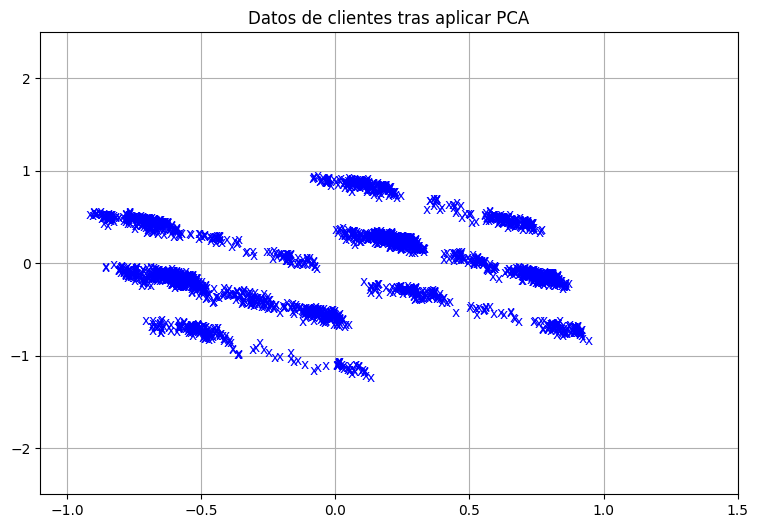

In [37]:
# Visualizar el dataset utilizando las dos dimensiones obtenidas en el PCA

plt.figure(figsize=(9, 6))
for i in range(len(X_pca)):
    plt.text(X_pca[i][0], X_pca[i][1], 'x', color="b")
plt.xlim(-1.1, 1.5)
plt.ylim(-2.5, 2.5)
plt.title("Datos de clientes tras aplicar PCA")
plt.grid()
plt.show()

# Ejecución del algoritmo de clustering jerárquico

---



A continuación, vamos a ejecutar un algoritmo de clustering jerárquico (notar que tardará un rato en ejecutarse) para ver cómo se distribuyen los datos.

Dado que la mayor parte de los datos no están muy concentrados y el resto parecen valores atípicos, es mejor utilizar como distancia intercluster el **vecino más próximo** (single). Las opciones más recomendadas para este problema van desde el **vecino más alejado** (complete) hasta la **mínima varianza** (ward).

Utilizaremos como distancia el vecino más cercano (single) ya que nos permitirá dividir los grupos más grandes. Se establece un umbral (threshold) de $15$ como distancia a partir de la cual se considerará que los grupos a distancia mayor son grupos independientes (y por lo tanto no se agruparan).


Distancia Media	   1.39


<ipython-input-38-d658ad38ca3e>:13: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = cluster.hierarchy.linkage(D, method='single')


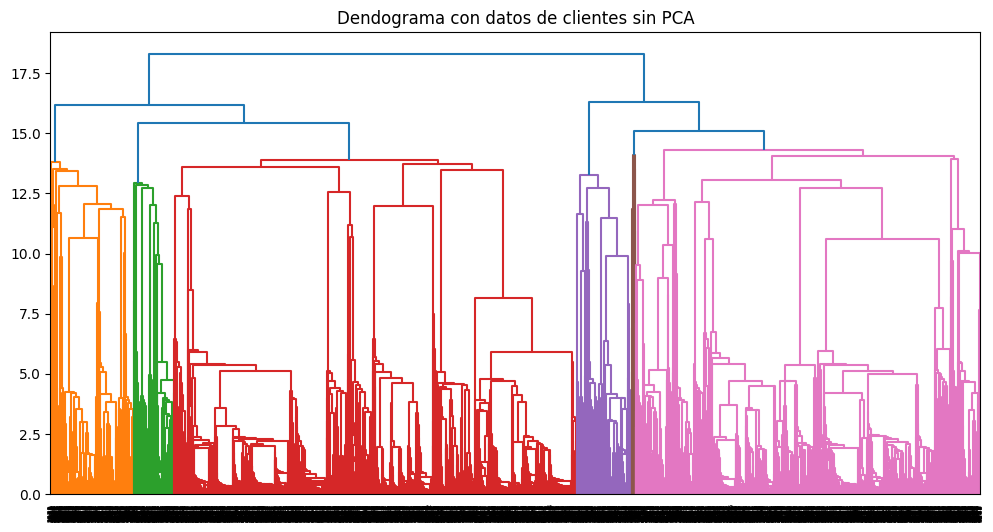

In [38]:
## Clustering jerárquico
# 1. Obtener la matriz de distancia entre todos los elementos

D = pairwise_distances(clients_scaled, metric='euclidean')

avD = np.average(D)
print("Distancia Media\t {:6.2f}".format(avD))

# 2. Constuimos el dendograma
plt.figure(figsize=(12, 6))
# Seleccionamos como distancia intercluster el vecino más alejado (complete)
# lusters = cluster.hierarchy.linkage(D, method='complete')
clusters = cluster.hierarchy.linkage(D, method='single')
# Cada fila del array clusters representa una fusión específica, indicando
#              * Qué clusters se combinaron (Columna1 y Columna2)
#              * La distancia entre ellos en el momento de su fusión
#              * El tamaño del nuevo cluster resultante.
cluster.hierarchy.dendrogram(clusters, color_threshold=15)
plt.title("Dendograma con datos de clientes sin PCA")
plt.show()

# Para más información consultar:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

Tras realizar el corte a una distancia de $15$ utilizando distancia intercluster el vecino más alejado (complete), obtenemos $7$ grupos. Este nivel de corte debe realizarse ad-hoc en un nível que consideremos lógico. En este caso concreto, vemos que realizar este corte nos da unos cuantos outiliers (grupos de un solo elemento).

A continuación vamos a obtener un vector (*labels*) que, dada una distancia de corte (*threshold*) y un criterio de distancia intercluster, contenga el grupo al que pertece cada elemento.

In [39]:
# 3. Obtenemos el grupo al que pertenece cada observación
threshold = 15 # ad-hoc
labels = cluster.hierarchy.fcluster(clusters, threshold , criterion='distance')

# ¿Cuántos grupos hay? Contamos el número de "labels" distintas en el vector
print("Número de clusters {}".format(len(set(labels))))
labels

Número de clusters 6


array([6, 1, 3, ..., 6, 6, 1], dtype=int32)

Ahora podemos volver a representar gráficamente los datos del PCA (en dos dimensiones) pero introduciendo como color los resultados de las etiquetas. Se puede ver que el clustering no ha quedado nada mal, los resultados son coherentes.

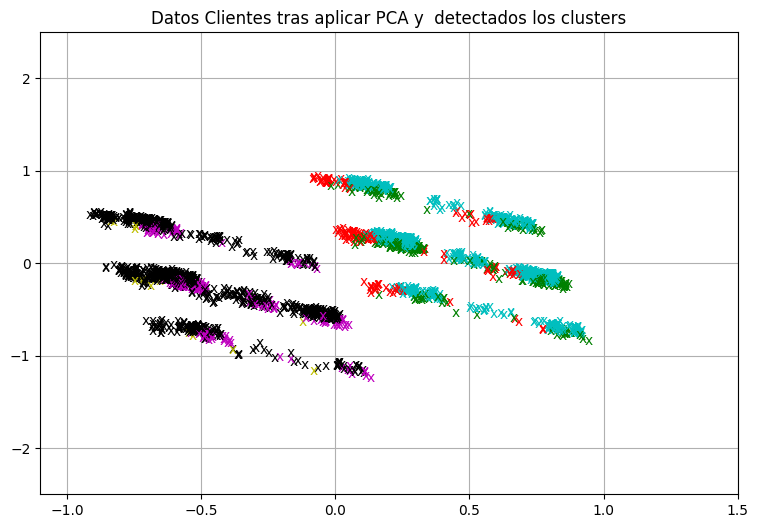

In [40]:
colores = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colores = np.hstack([colores] * 20)

plt.figure(figsize=(9, 6))
for i in range(len(X_pca)):
    plt.text(X_pca[i][0], X_pca[i][1], 'x', color=colores[labels[i]])
plt.xlim(-1.1, 1.5)
plt.ylim(-2.5, 2.5)
plt.grid()
plt.title("Datos Clientes tras aplicar PCA y  detectados los clusters")
plt.show()

##CSV

Ahora añadimos el cluster al dataframe y lo exportamos a csv para abrirlo con el excel

In [41]:
# Asocia cada muestra a su cluster
df_clients['cluster'] = labels

# Exporta el DataFrame a un archivo CSV
df_clients.to_csv('clientes_segmentados_clusters.csv', index=False)

print("Archivo 'clientes_segmentados_clusters.csv' exportado correctamente.")

Archivo 'clientes_segmentados_clusters.csv' exportado correctamente.


## Excel

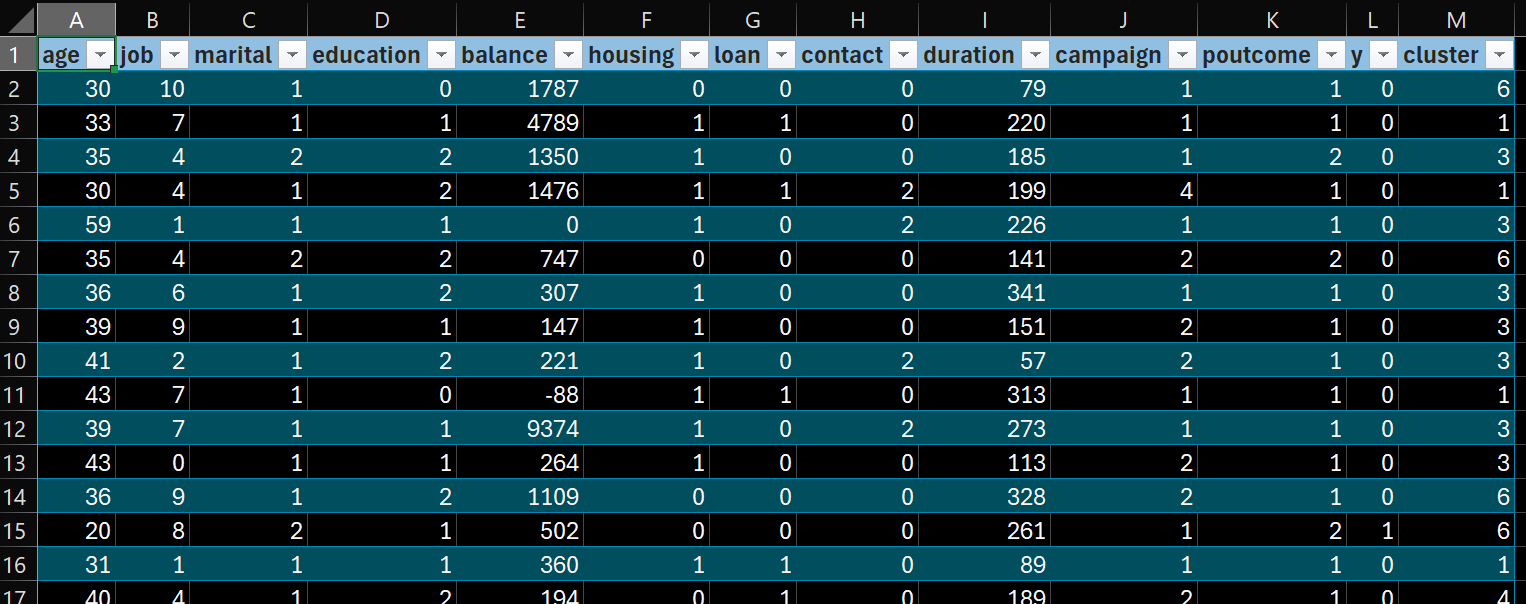

## Data Wrangler

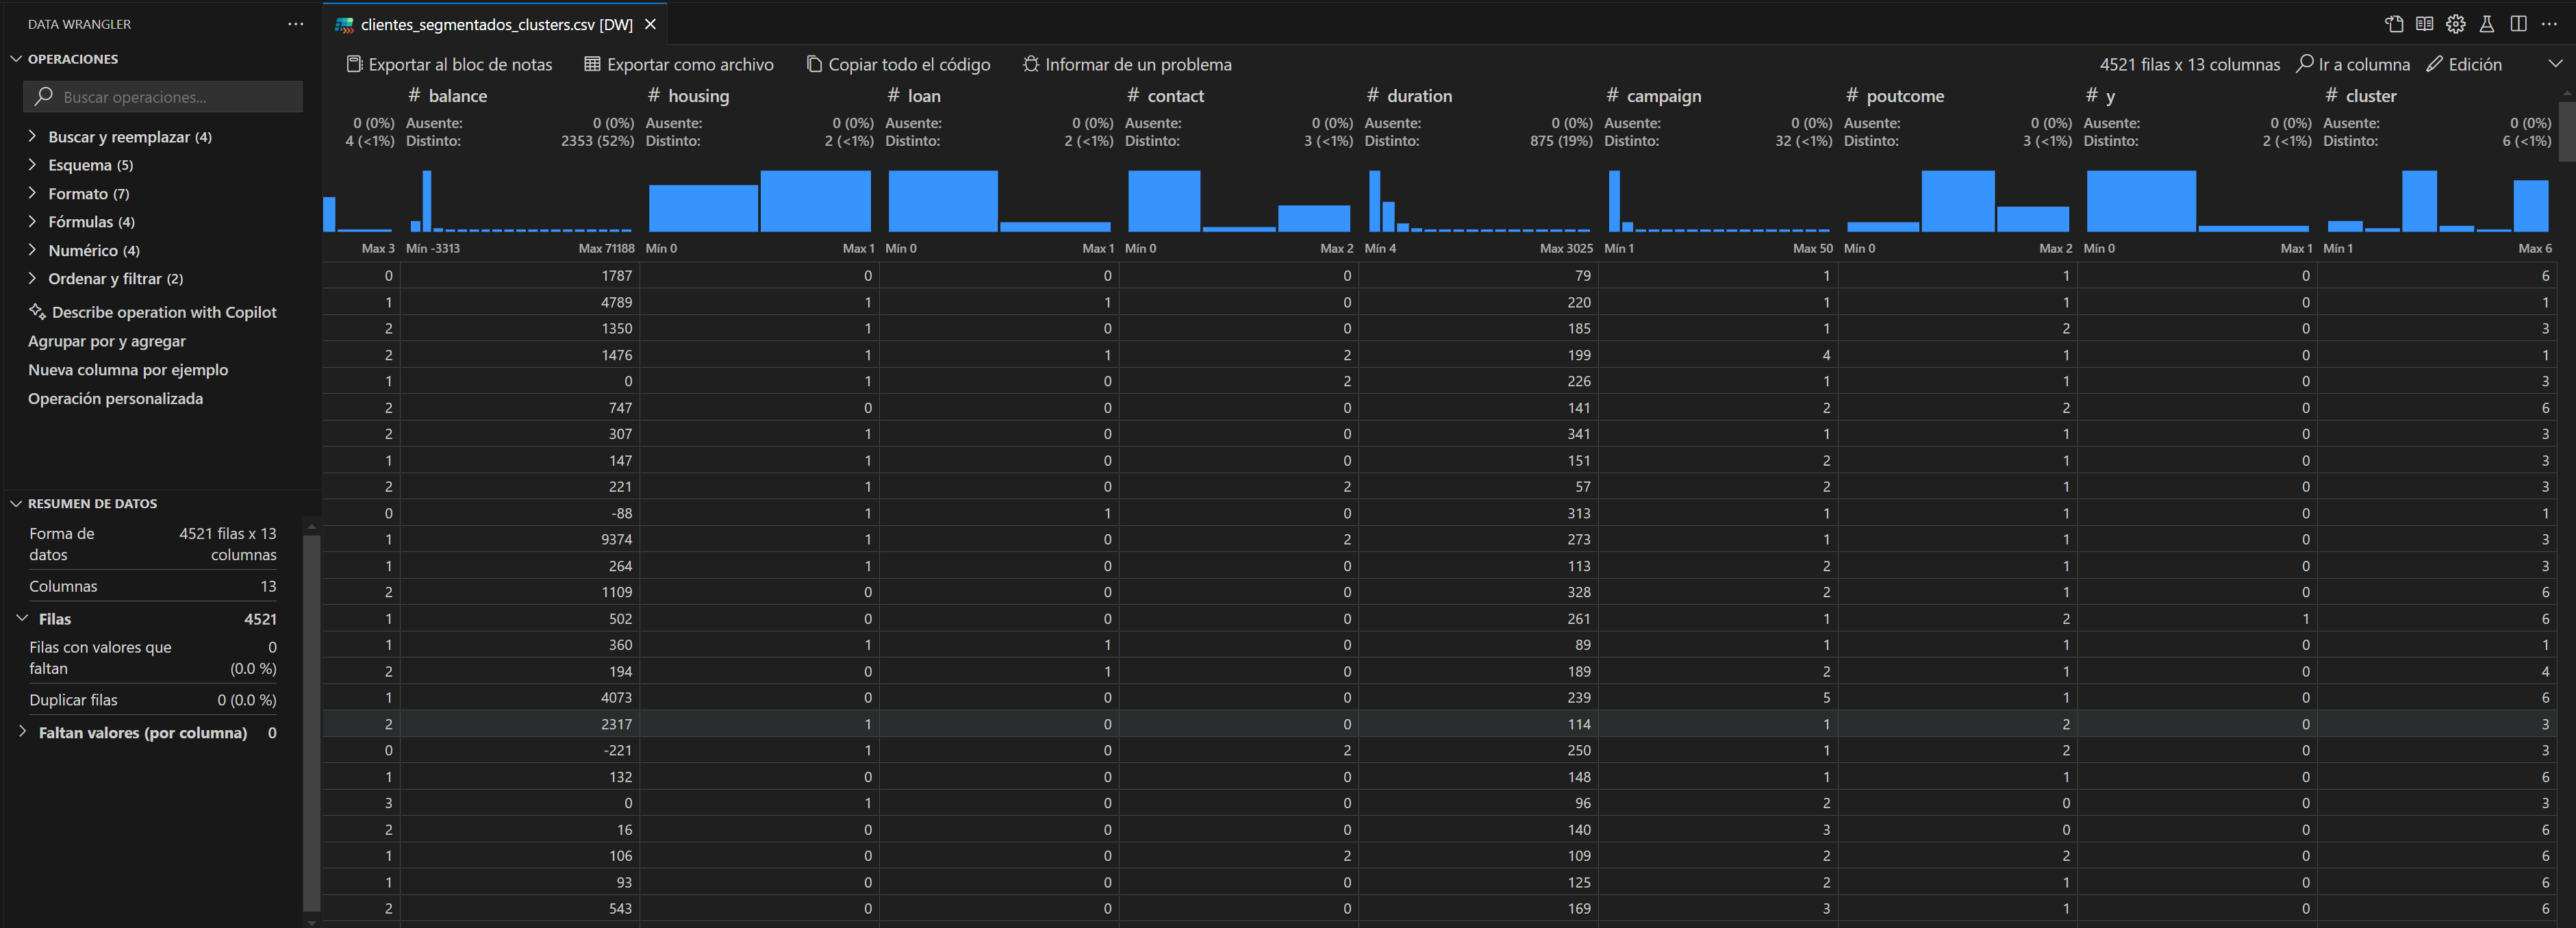